# Code

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import nn, optim
from torch.utils import data

import warnings

%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

In [2]:
# Logarithmic transformation of a highly skewed variables into a more normalized view
def eda(X_train, X_test):
    n_train = X_train.shape[0]
    X = pd.concat((X_train, X_test)).reset_index(drop=True)

    numerical_features = ['Age', 'Debt', 'YearsEmployed', 'ZipCode', 'Income']
    categorical_features = [
        'Gender', 'Married', 'BankCustomer', 'Industry', 'Ethnicity',
        'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'Citizen'
    ]

    X[numerical_features] = np.log(X[numerical_features].replace(0, np.nan)).fillna(0)
    return X, n_train, numerical_features, categorical_features

In [3]:
# Features encoding
def preprocessing(X, n_train, numerical_features, categorical_features):
    X[numerical_features] = StandardScaler().fit_transform(X[numerical_features])
    X[categorical_features] = X[categorical_features].apply(LabelEncoder().fit_transform)

    X_train, X_test = X[:n_train], X[n_train:]
    return X_train, X_test

In [4]:
# Custom dataset class
class Dataset(data.Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, item):
        return self.X[item], self.y[item]

In [5]:
# Neural network architecture
class CreditCardNet(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(CreditCardNet, self).__init__()
        self.layer_1 = nn.Linear(15, n_hidden_neurons)
        self.layer_out = nn.Linear(n_hidden_neurons, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.layer_out(x)
        return x

In [6]:
# Accuracy calculation
def bin_acc(y_pred, y_test):
    y_pred = torch.round(torch.sigmoid(y_pred))
    correct_result_sum = (y_pred == y_test).sum().float()
    acc = correct_result_sum / y_test.shape[0]
    acc = torch.round(acc)
    return acc

In [7]:
def training(epochs, model, optimizer, loss, train_dl, valid_dl):
    train_losses, valid_losses, valid_accuracies = [], [], []

    for epoch in range(epochs):
        epoch_loss, epoch_acc = 0, 0
        model.train()

        for X_batch, y_batch in train_dl:
            optimizer.zero_grad()

            y_pred = model.forward(X_batch)
            loss_value = loss(y_pred, y_batch.unsqueeze(1))
            epoch_loss += loss_value
            loss_value.backward()

            optimizer.step()

        train_losses.append(epoch_loss.detach().cpu().numpy()/len(train_dl))

        model.eval()
        with torch.no_grad():
            epoch_loss, epoch_acc = 0, 0
            for X_batch, y_batch in valid_dl:
                y_pred = model(X_batch)
                loss_value = loss(y_pred, y_batch.unsqueeze(1))
                acc = bin_acc(y_pred, y_batch.unsqueeze(1))
                epoch_loss += loss_value
                epoch_acc += acc

            valid_losses.append(epoch_loss.detach().cpu().numpy()/len(valid_dl))
            valid_accuracies.append(epoch_acc.detach().cpu().numpy()/len(valid_dl))
            print(f"Epoch {epoch} | Loss: {epoch_loss/len(valid_dl):.3f} | Accuracy: {epoch_acc/len(valid_dl):.2f}")

    return train_losses, valid_losses, valid_accuracies

def testing(model, test_dl):
    model.eval()
    y_pred_list = []
    with torch.no_grad():
        for X_batch in test_dl:
            y_test_pred = torch.round(torch.sigmoid(model(X_batch)))
            y_pred_list.append(y_test_pred.detach().cpu().numpy())
    predictions = [np.squeeze(y_test_pred).tolist() for y_test_pred in y_pred_list]
    return predictions

In [8]:
# Parameter setting
def fit(path_to_train="./data/train.csv", path_to_test="./data/test.csv",
        filename="./models/pytorch_model.pt", save_model=False, conf_matrix=True):
    train = pd.read_csv(path_to_train)
    test = pd.read_csv(path_to_test)

    X_train, y_train = train.drop('Approved', axis=1), train['Approved']
    X_test, y_test = test.drop('Approved', axis=1), test['Approved']
    X_train, X_test = preprocessing(*eda(X_train, X_test))

    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
    print("Train size:", X_train.shape[0], "| Valid size:", X_valid.shape[0], "| Test size:", X_test.shape[0])

    train_data = Dataset(X_train, y_train)
    valid_data = Dataset(X_valid, y_valid)
    test_data = Dataset(X_test, y_test)

    N_NEURONS = 5
    BATCH_SIZE = 2**5
    LEARNING_RATE = 1e-1
    EPOCHS = 7

    model = CreditCardNet(N_NEURONS)
    loss = nn.BCEWithLogitsLoss()  # automatically applies to the Sigmoid function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train the model
    train_loader = data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = data.DataLoader(dataset=valid_data, batch_size=BATCH_SIZE, shuffle=False)
    info = training(EPOCHS, model, optimizer, loss, train_loader, valid_loader)
    plot_training(*info)

    # Saving the model
    if save_model:
        torch.save(model.state_dict(), filename)
        model = CreditCardNet(N_NEURONS)
        model.load_state_dict(torch.load(filename))

    # Test the model
    test_loader = data.DataLoader(dataset=test_data.X, batch_size=1, shuffle=False)
    predictions = testing(model, test_loader)

    # Confusion Matrix
    if conf_matrix:
        plot_conf_matrix(y_test, predictions)

    return predictions, y_test

In [9]:
# To show Confusion Matrix
def plot_conf_matrix(y_test, predictions):
    conf_matrix = confusion_matrix(y_test, predictions)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]

    labels = [f"{l1}\n{l2}\n{l3}" for l1, l2, l3  in zip(group_names, group_counts, group_percentages)]
    labels = np.array(labels).reshape(2, 2)

    plt.figure(figsize=(3, 2))
    ax = sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title("Confusion Matrix\n")
    ax.set_xlabel("\nPredicted values")
    ax.set_ylabel("Actual values")
    ax.xaxis.set_ticklabels(['False', 'True'])
    ax.yaxis.set_ticklabels(['False', 'True'])
    plt.show();

In [10]:
# Visualization of loss and accuracy
def plot_training(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(4, 4))
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label="Train loss")
    plt.plot(valid_losses, label="Valid loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Loss for each epoch")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(valid_accuracies, label="Valid accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title("Accuracy for each epoch")
    plt.legend()

    plt.tight_layout()
    plt.show();

# Make prediction

Train size: 512 | Valid size: 128 | Test size: 50
Epoch 0 | Loss: 0.394 | Accuracy: 1.00
Epoch 1 | Loss: 0.373 | Accuracy: 1.00
Epoch 2 | Loss: 0.337 | Accuracy: 1.00
Epoch 3 | Loss: 0.340 | Accuracy: 1.00
Epoch 4 | Loss: 0.316 | Accuracy: 1.00
Epoch 5 | Loss: 0.307 | Accuracy: 1.00
Epoch 6 | Loss: 0.338 | Accuracy: 1.00


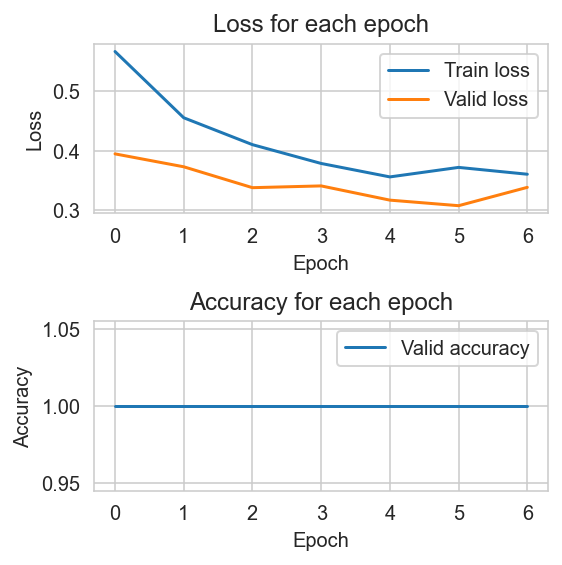

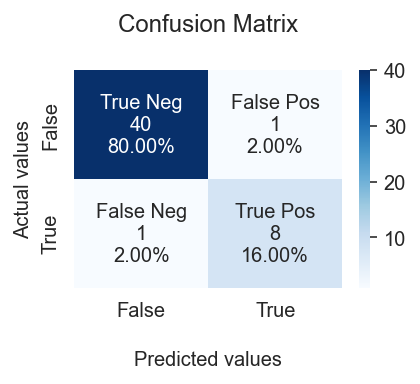

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        41
           1       0.89      0.89      0.89         9

    accuracy                           0.96        50
   macro avg       0.93      0.93      0.93        50
weighted avg       0.96      0.96      0.96        50



In [14]:
predictions, y_test = fit()
print(classification_report(y_test, predictions))